<a href="https://colab.research.google.com/github/saideepakmara/Melanoma_classification/blob/main/elmisaurus_rodeo_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

We train a CNN model on ISIC 2017 dataset for classifying benign and malignant skin diseases. Our goal is to compare the accuracy of different Network Architectures on skin disease classification.

We use CycleGAN for transforming synthetic skin disease images into realistic images.

We train these networks on both CycleGAN generated and real images and compare their accuracy.

## Hypothesis
EfficientNet achieves higher accuracy on skin disease classification than ResNet, VGG and AlexNet.

Models trained on CycleGAN images achieve similar accuracy with models trained on real images.

## Dataset
[ISIC 2017 dataset for classifying malignant and benign skin diseases](https://challenge.isic-archive.com/landing/2017/)

[ISIC 2017 paper on the database](https://arxiv.org/pdf/1710.05006.pdf)

[Synthetically generated images of malignant and benign skin disease](https://affect.media.mit.edu/dissect/synthderm/)



---
# Setup

In [ ]:
#@title Install dependencies

import os
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import confusion_matrix
from skimage.io import imread, imsave
from skimage.transform import resize

%matplotlib inline

In [ ]:
# @title Helper functions
def load_image(filename):

  image = imread(filename)
  # img is uint8 in [0, 255], but we want float32 in [-1, 1]
  image = image.astype(np.float32)/255.0
  image = (image - 0.5)/0.5

  return image

def plot_losses(train_losses, val_losses):

    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Train Loss', color='blue', linestyle='solid')

    plt.plot(val_losses, label='Validation Loss', color='orange',
             linestyle='dashed')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

def show_batch(x, y, batch_size=32):
    num_rows = 2
    num_cols = 4

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 7), sharey=True, sharex=True)

    for i in range(min(batch_size, 8)):
        row = i // num_cols
        col = i % num_cols

        # Convert the [-1, 1] float32 tensors to uint8 [0, 255] numpy array.
        img = np.squeeze(x[i])
        img = img * 0.5 + 0.5
        img = (img * 255.0).numpy().astype(np.uint8)

        axs[row, col].imshow(img)
        axs[row, col].set_title(train_dataset.dataset.classes[y[i].item()])
        axs[row, col].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.show()

def get_all_predictions(model, device, data_loader):
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        model.eval()
        for inputs, targets in data_loader:

            inputs, targets = inputs.to(device), targets.to(device)
            inputs = torch.permute(inputs, (0, 3, 1, 2))
            outputs = model(inputs)

            outputs = torch.sigmoid(outputs)
            predicted = torch.round(outputs)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_preds, all_targets

def model_to_drive(model, fname):
    #Save a PyTorch model to a file
    save_path = f'/content/drive/MyDrive/elmisaurus_rodeo_project/saves/{fname}'
    torch.save(model.state_dict(), save_path)

def save_to_csv(dataframe, fname):
    #Save a dataframe to a file
    save_path = f'/content/drive/MyDrive/elmisaurus_rodeo_project/saves/{fname}'
    dataframe.to_csv(save_path, index=False)

def get_from_csv(fname):
    #Get a dataframe from a file
    save_path = f'/content/drive/MyDrive/elmisaurus_rodeo_project/saves/{fname}'
    return pd.read_csv(save_path)

#copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



In [ ]:
# @title Set random seed
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

SEED = 2023
generator = torch.Generator().manual_seed(SEED)
set_seed(seed=SEED, seed_torch=SEED)

Random seed 2023 has been set.


## Load the data (from the website) *skip


In [ ]:
# @title Download the data
#!wget -O full_data.zip https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
#!wget -O ground_truth.csv https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part3_GroundTruth.csv

# Unzipping the file creates a train folder so we change
#!unzip -q full_data.zip

#!mv ISIC-2017_Training_Data full_data

#!rm full_data/ISIC-2017_Training_Data_metadata.csv
#!rm full_data/*superpixels*

In [ ]:
# @title Sort the data into two folders
def is_melanoma(filename, df):
  #Get the filename and remove the .jpg suffix
  im_name = filename.name[:-4]
  #Return the target (0 for benign, 1 for malignant)
  return df[df.image_id == im_name].iloc[0, 1]

def sort_melanoma(dataset_folder_name, ground_truth_filename):
  host_dir = Path.cwd() / dataset_folder_name
  df = pd.read_csv(ground_truth_filename)
  none = host_dir / "none"
  present = host_dir / "melanoma"

  # Create two class folders
  none.mkdir(parents=True, exist_ok=True)
  present.mkdir(parents=True, exist_ok=True)

  # Go through the files and sort them
  for fn in host_dir.iterdir():
    if(fn.is_file() and len(fn.name) == 16):
      if is_melanoma(fn, df):
        new_path = host_dir / present
      else:
        new_path = host_dir / none

      fn.replace(new_path / fn)
      #Resize the images (224, 224)
      #img = imread(fn)
      #img = resize(img, (224, 224))
      #img = (img*255).astype(np.uint8)
      #imsave(new_path / fn.name, img)
      #fn.unlink()

#dataset_folder_name   = "full_data"
#ground_truth_filename = "ground_truth.csv"

#sort_melanoma(dataset_folder_name, ground_truth_filename)

In [ ]:
# @title Upload data to google drive
#from google.colab import drive
#drive.mount('/content/drive')

#!cp -r full_data /content/drive/MyDrive

## Load the preprocessed data (from the google drive) *skip


In [ ]:
# @title Download the data
#!gdown 1-LZsyiEAbN3f3vKcaZr-djzxCAX96Rn1
#!wget -O ground_truth.csv https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part3_GroundTruth.csv

# Unzipping the file creates a train folder so we change
#!unzip -q full_data.zip

---
## Load the balanced data (from the google drive)

In [ ]:
# @title Download the data
!gdown 14-Q58ZCNvFK-NPIIcmATLpOvMD6PS7DM
!unzip -q full_data.zip

Downloading...
From: https://drive.google.com/uc?id=14-Q58ZCNvFK-NPIIcmATLpOvMD6PS7DM
To: /content/full_data.zip
100% 18.2M/18.2M [00:00<00:00, 50.7MB/s]


# Data loaders for training, validation and testing

In [ ]:
FULL_DATASET_ROOT = '/content/full_data'
TRAIN_PERCENT = 0.7
VAL_PERCENT = 0.15

full_dataset = ImageFolder(root=FULL_DATASET_ROOT, loader=load_image)

num_images = len(full_dataset)

num_training = int(TRAIN_PERCENT * num_images)
num_validation = int(VAL_PERCENT * num_images)
num_test = num_images - (num_training + num_validation)

# Randomly split the dataset into training, validation, and test sets
train_dataset, validation_dataset, test_dataset = random_split(
    full_dataset,
    [num_training, num_validation, num_test],
    generator=generator)

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, drop_last=True, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

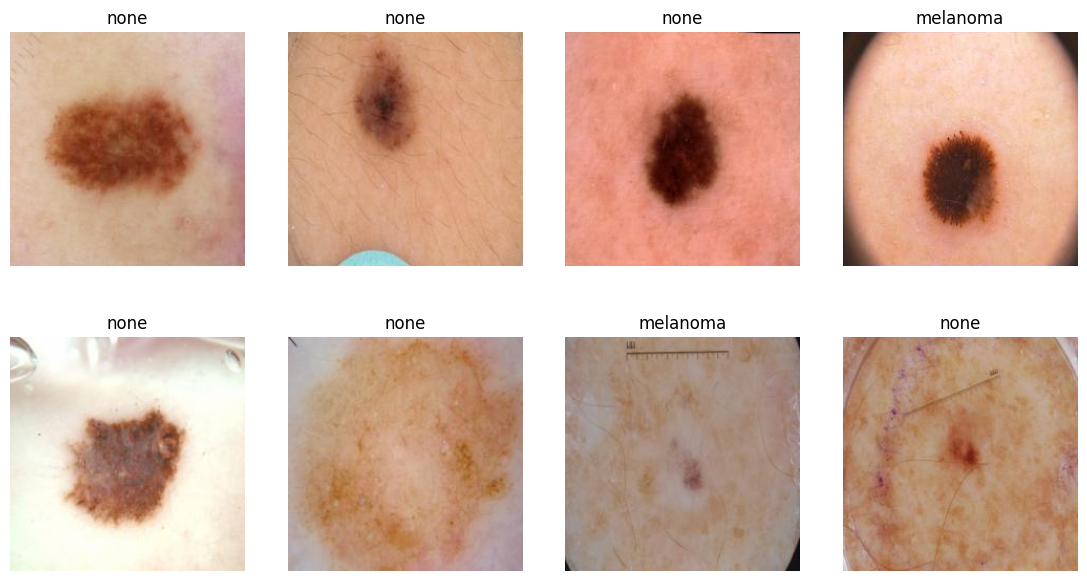

In [ ]:
# @title Looking at a random batch
# @markdown run this cell repeatedly to see different batches

# show a random batch from the data loader
for x, y in train_loader:
  show_batch(x, y)
  break

Text(0.5, 1.0, 'augmented')

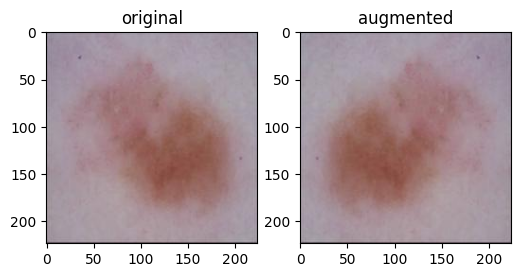

In [ ]:
#@title Looking at augmented data

fig = plt.figure(figsize=(6, 6))
path_for_augmented = Path('/content/full_data/melanoma')

fig.add_subplot(1, 2, 1)
image = imread(path_for_augmented/"ISIC_0000026.jpg")
plt.imshow(image)
plt.title("original")

fig.add_subplot(1, 2, 2)
image = imread(path_for_augmented/"augmented_v2_0000026.jpg")
plt.imshow(image)
plt.title("augmented")

---
# Model creation

## Simple CNN

In [ ]:
class SimpleCNN(nn.Module):
  """
  Simple Convolutional Neural Networks architecture for classifying melanoma.
  Based on LeNet.
  Input images are in (8, 3, 224, 224) format.
  Conv
  (16, 220, 220)
  Pooling
  (16, 110, 110)
  Conv
  (32, 108, 108)
  Pooling
  (32, 54, 54)
  Conv
  (64, 52, 52)
  Pooling
  (64, 26, 26)
  Flatten
  (64 * 26 * 26)
  FC
  (512)
  FC
  (1)
  """
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.fc1 = nn.Linear(in_features=64*26*26, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=1)
    self.dropout = nn.Dropout(p=0.5)
    self.pool = nn.MaxPool2d(kernel_size=2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.fc2((F.relu(self.fc1(self.dropout(torch.flatten(x, 1))))))
    return x

model = SimpleCNN()

## Not-So-Simple CNN

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
class CNN_2(nn.Module):
  """
  Simple Convolutional Neural Networks architecture for classifying melanoma.
  Based on LeNet and ResNet.

  Input #[Batch, Channels, Height, Width].
  ->     (Batch_size, 3, 224, 224)
  7x7 conv, 64, /2, padding: 1
  ->     (Batch_size, 64, 220, 220)
  pool, /2
  ->     (Batch_size, 64, 110, 110)

  3x3 conv, 64
  ->     (Batch_size, 64, 108, 108)
  pool, /2
  ->     (Batch_size, 64, 54, 54)

  3x3 conv, 64
  ->     (Batch_size, 64, 52, 52)
  pool, /2
  ->     (Batch_size, 64, 26, 26)

  3x3 conv, 128
  ->     (Batch_size, 128, 24, 24)
  pool, /2
  ->    (Batch_size, 128, 12, 12)

  fc
  """
  def __init__(self, batch_size=32):
    super(CNN_2, self).__init__()

    self.bigblock = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

    self.midblock1 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )


    self.midblock2 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.smallblock = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fc = nn.Linear(in_features= 128 * 12 * 12, out_features=1)

  def forward(self, x):
    x = self.bigblock(x)
    x = self.midblock1(x)
    x = self.midblock2(x)
    x = self.smallblock(x)
    return self.fc(torch.flatten(x, 1))

model = CNN_2()

## Tiny VGG

In [ ]:
# Create a convolutional neural network
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape = 3, hidden_units=10, output_shape=1):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,  # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units * 56 * 56,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

## ResNet

In [ ]:
resnet = torchvision.models.resnet18(weights=None)
num_ftrs = resnet.fc.in_features
# ResNet final fully connected layer
resnet.fc = nn.Linear(num_ftrs, 1)
model = resnet

## EfficientNet

In [ ]:
efficientnet = torchvision.models.efficientnet_b0(weights=None)

# Change the classifier layer for our problem
efficientnet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                        nn.Linear(1280, 1))
model = efficientnet

---
## Transfer Learning

In [ ]:
resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

#Fine tune only the last layer
#for param in resnet.parameters():
#  param.requires_grad = False

# Change the classifier layer for our problem
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)
model = resnet


In [ ]:
efficientnet = torchvision.models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

##Fine tune only the last layer
#for param in efficientnet.parameters():
#  param.requires_grad = False

# Change the classifier layer for our problem
efficientnet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                        nn.Linear(1280, 1))
model = efficientnet

---
# Training

In [ ]:
# @title Train/Test Functions
def evaluate(model, device, data_loader, criterion):
    """
    Evaluate the model on the given DataLoader.

    Args:
        model (nn.Module): The neural network model to be evaluated.
        device (str): 'cuda' if GPU/CUDA is available, otherwise 'cpu'.
        data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.
        criterion (torch.nn.Module): The loss function used for evaluation.

    Returns:
        tuple: A tuple containing the validation loss (float) and accuracy (float).
    """
    model.eval()

    correct = 0
    total = 0
    loss = 0.0

    with torch.inference_mode():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
             #[BatchSize,Height,Width,Channel] -> [BatchSize,Channels,Height,Width]
            inputs = torch.permute(inputs, (0, 3, 1, 2))
            labels = labels.to(device).to(torch.float32)

            outputs = model(inputs).squeeze()
            loss += criterion(outputs, labels).item()

            outputs = torch.sigmoid(outputs)
            predicted = torch.round(outputs)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    loss /= len(data_loader)
    return loss, accuracy


def train(model, device, train_loader, validation_loader, criterion, optimizer, epochs):
    """
    Training function for the neural network model.

    Args:
        model (nn.Module): The neural network model to be trained.
        device (str): 'cuda' if GPU/CUDA is available, otherwise 'cpu'.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        validation_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimization algorithm.
        epochs (int): Number of training epochs.

    Returns:
        A tuple containing list of test and validation losses.
    """
    model.train()
    train_losses = []
    val_losses = []

    early_stopping = EarlyStopper(patience=3, min_delta=0.2)

    for epoch in range(epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            model.train()
            running_train_loss = 0.0
            for data, target in tepoch:
                data, target = data.to(device), target.to(device).to(torch.float32)
                data = torch.permute(data, (0, 3, 1, 2))

                optimizer.zero_grad()
                output = model(data).squeeze()
                loss = criterion(output, target)

                #L1 regularization
                #l1_lambda = 0.001
                #l1 = 0.0
                #for param in model.parameters():
                #  l1 += torch.sum(torch.abs(param))
                #loss += l1_lambda * (l1)

                loss.backward()
                optimizer.step()

                tepoch.set_postfix(loss=loss.item())
                running_train_loss += loss.item()

            # Calculate average training and validation loss for the epoch
            train_loss = running_train_loss / len(train_loader)
            train_losses.append(train_loss)

            val_loss, val_accuracy = evaluate(model, device, validation_loader, criterion)
            val_losses.append(val_loss)

            if early_stopping.early_stop(val_loss):
              break

            if epoch % 10 == 0:
                print(f"Epoch {epoch} - Validation Loss: {val_loss:.2f}\nValidation Accuracy: {val_accuracy:.2f}")

    return train_losses, val_losses

In [ ]:
#@title Initialize the arguments
epochs = 100
lr = 1e-4
l2_lambda = 0.001
momentum = 0.90
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Choose the loss function and optimizers
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr)

#SGD with momentum
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#SGD with L2 regularization
#optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_lambda)

#SGD with both momentum and regularization
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=l2_lambda)

#Adam
optimizer = optim.Adam(model.parameters(), lr=lr)

#Adam with L2 regularization
#ptimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model.to(device)
print(model)
print(f"Total trainable params: {total_params}")

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=43264, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Total trainable params: 22176545


In [ ]:
train_losses, val_losses = train( model=model,
                                  device=device,
                                  train_loader=train_loader,
                                  validation_loader=val_loader,
                                  criterion=criterion,
                                  optimizer=optimizer,
                                  epochs=epochs,
                                  )

100%|██████████| 71/71 [00:06<00:00, 11.50batch/s, loss=0.678]


Epoch 0 - Validation Loss: 0.66
Validation Accuracy: 0.58


100%|██████████| 71/71 [00:05<00:00, 12.29batch/s, loss=0.517]


Epoch 10 - Validation Loss: 0.57
Validation Accuracy: 0.68


100%|██████████| 71/71 [00:06<00:00, 11.67batch/s, loss=0.333]


Epoch 20 - Validation Loss: 0.56
Validation Accuracy: 0.75


100%|██████████| 71/71 [00:05<00:00, 12.30batch/s, loss=0.195]


Epoch 30 - Validation Loss: 0.61
Validation Accuracy: 0.75


100%|██████████| 71/71 [00:06<00:00, 11.76batch/s, loss=0.0524]


In [ ]:
#@title Testing

test_loader = DataLoader(test_dataset, batch_size=32)
test_loss, test_acc = evaluate(model, device, test_loader, criterion)
print(f"Test loss: {test_loss}\n Test accuracy: {test_acc}")

Test loss: 0.863584604114294
 Test accuracy: 0.7484662576687117


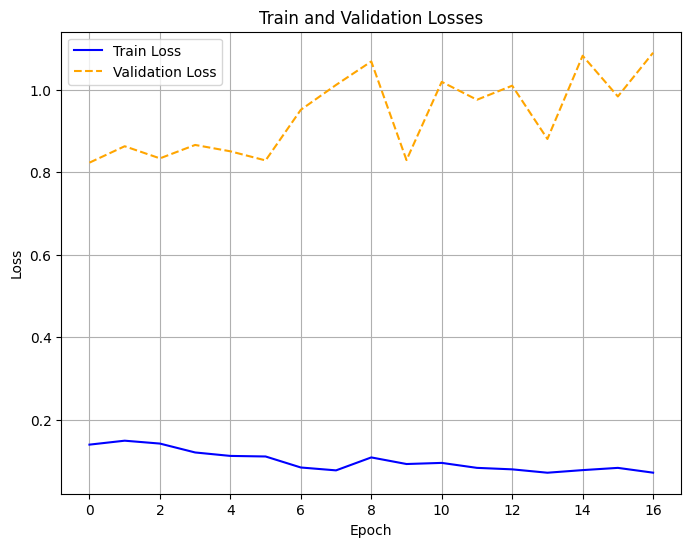

In [ ]:
#@title Visualizing the loss
plot_losses(train_losses, val_losses)

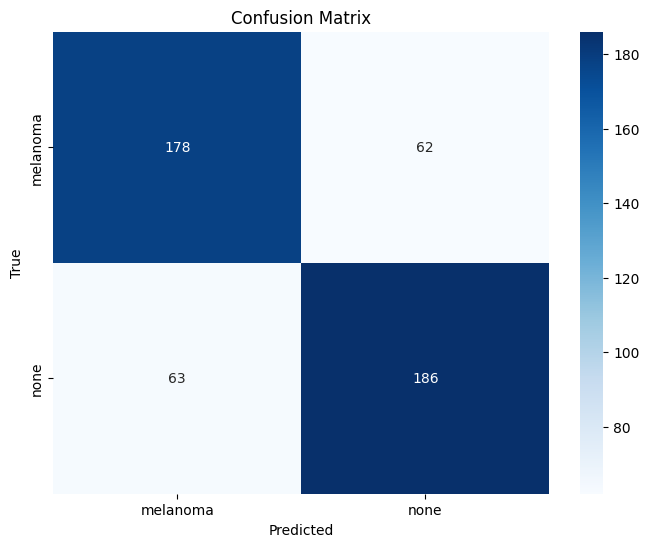

In [ ]:
#@title Plot a confusion matrix

# Get predictions and ground truth labels for the test dataset
all_preds, all_targets = get_all_predictions(model, device, test_loader)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

# Define the class labels (if available)
class_labels = full_dataset.classes

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

plt.show()


---
# Uploading the experimental results to google drive

In [ ]:
#@title Upload training and validation loss records
from google.colab import drive
drive.mount('/content/drive')

#@markdown ---
#@markdown ### Name of the model:
name_of_the_model = 'ResNet_Adam' #@param ['SimpleCNN_', 'TinyVGG_', 'CNN_2_', 'ResNet_', 'EfficientNet_'] {allow-input:true}
#@markdown ### Save the model to a drive?
save_the_model = False #@param {type:"boolean"}
#@markdown ---

# Create a DataFrame for the model's losses
model_df = pd.DataFrame({'Model': name_of_the_model, 'Epoch': range(1, len(train_losses) + 1),
                          'Train Loss': train_losses, 'Validation Loss': val_losses})

fname = name_of_the_model + '.csv'
save_to_csv(model_df, fname)

if(save_the_model):
  model_to_drive(model, fname= name_of_the_model + )

Mounted at /content/drive


#Data analysis

In [ ]:
import glob
from google.colab import drive

drive.mount('/content/drive')
SAVE_PATH =  Path('/content/drive/MyDrive/elmisaurus_rodeo_project/saves/')

models_df = pd.DataFrame()

for fname in list(SAVE_PATH.glob('*.csv')):
  temp_df = pd.read_csv(fname)
  models_df = pd.concat([models_df, temp_df])
models_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Model,Epoch,Train Loss,Validation Loss
0,SimpleCNN_base,1,0.689032,0.684772
1,SimpleCNN_base,2,0.676481,0.680296
2,SimpleCNN_base,3,0.666279,0.669932
3,SimpleCNN_base,4,0.661142,0.674455
4,SimpleCNN_base,5,0.653987,0.670320
...,...,...,...,...
95,ResNet_Adam_L2_reg,96,0.007590,0.802142
96,ResNet_Adam_L2_reg,97,0.008791,0.943716
97,ResNet_Adam_L2_reg,98,0.004524,0.821234
98,ResNet_Adam_L2_reg,99,0.003659,0.869069


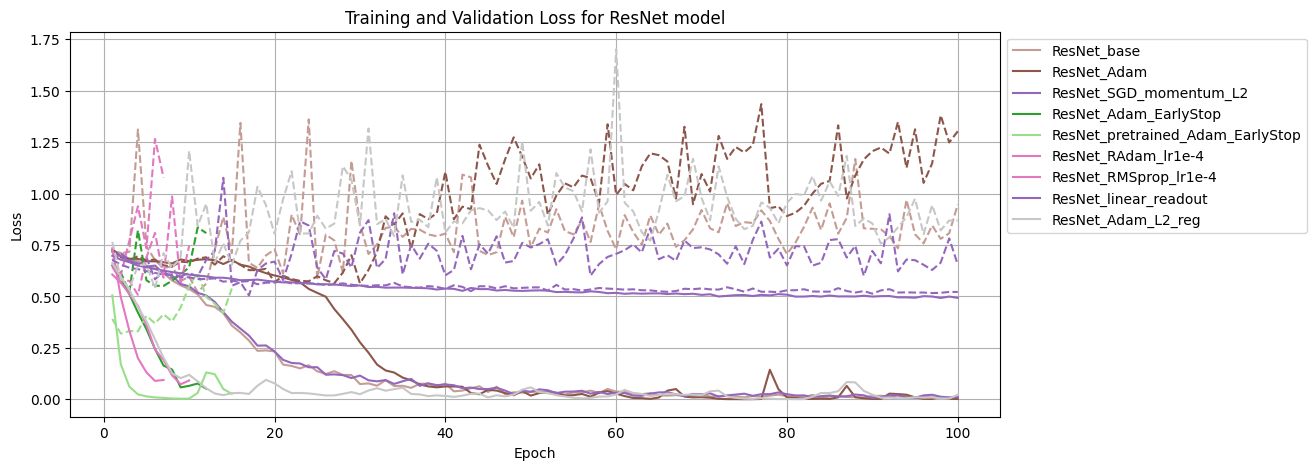

In [ ]:
# @title Visualizing the losses

model_names = models_df['Model'].unique()
model_name = 'ResNet' #@param ['ResNet', 'SimpleCNN', 'TinyVGG', 'CNN_2', 'EfficientNet']

fig, ax = plt.subplots(figsize=(12,5))

for model in model_names:
    if(model_name in model):
      model_data = models_df[models_df['Model'] == model]

      epochs = model_data['Epoch']
      train_loss = model_data['Train Loss']
      validation_loss = model_data['Validation Loss']

      #Use the same color for both training and validation lines
      color = plt.cm.tab20(hash(model) % 20)  # Select a color from the 'tab20' colormap

      ax.plot(epochs, train_loss, label=f'{model}', color=color, ls='-')
      ax.plot(epochs, validation_loss, color=color, ls='--')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss for {model_name} model')

ax.legend(bbox_to_anchor=(1,1))
ax.grid(True)

fig.show()

100
100
100
12
15
10
7
100
100
ResNet_base
100
         Model  Epoch  Train Loss  Validation Loss
0  ResNet_base      1    0.721532          0.70065
ResNet_base
100
         Model  Epoch  Train Loss  Validation Loss
0  ResNet_base      1    0.721532          0.70065
ResNet_base
100
         Model  Epoch  Train Loss  Validation Loss
0  ResNet_base      1    0.721532          0.70065
ResNet_base
100
         Model  Epoch  Train Loss  Validation Loss
0  ResNet_base      1    0.721532          0.70065
ResNet_base
100
         Model  Epoch  Train Loss  Validation Loss
0  ResNet_base      1    0.721532         0.700650
1  ResNet_base      2    0.711292         0.709096
ResNet_base
100
         Model  Epoch  Train Loss  Validation Loss
0  ResNet_base      1    0.721532         0.700650
1  ResNet_base      2    0.711292         0.709096
2  ResNet_base      3    0.677693         0.717140
ResNet_base
100
         Model  Epoch  Train Loss  Validation Loss
0  ResNet_base      1    0.721532        

CalledProcessError: ignored

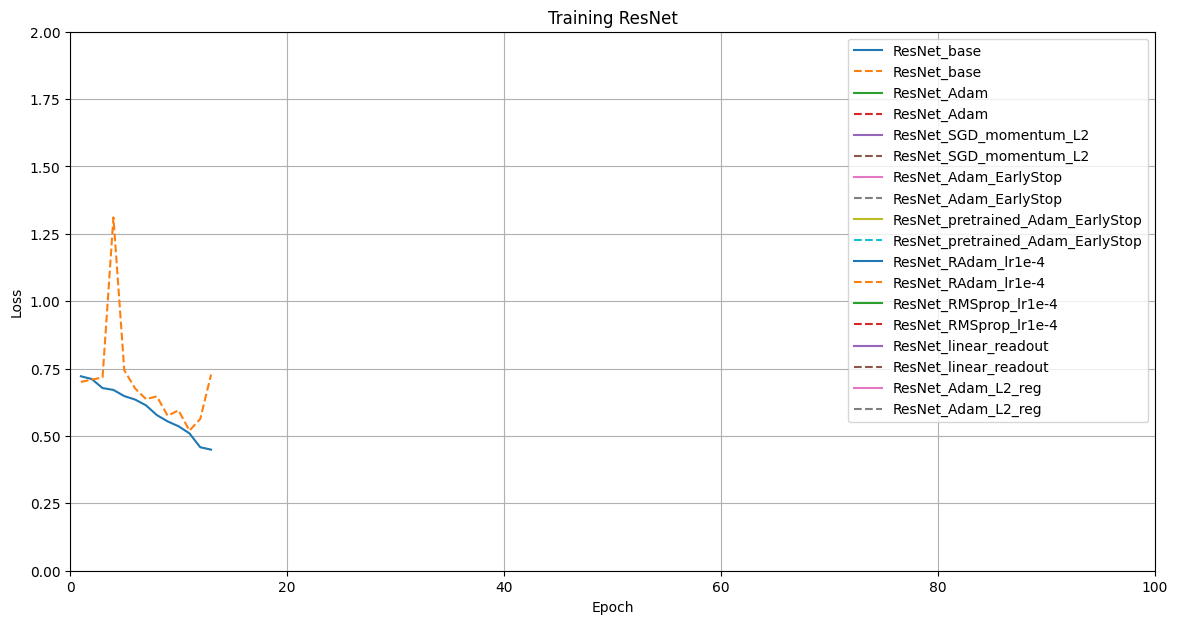

In [ ]:
# @title Loss animation
from matplotlib.animation import FuncAnimation

# Separate data for each model
models = models_df['Model'].unique()

model_name = 'ResNet' #@param ['ResNet', 'SimpleCNN', 'TinyVGG', 'CNN_2', 'EfficientNet']

# Get the list of model names starting with ResNet
new = []
for model in models:
  if(model_name in model):
    new.append(model)
models = new

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(14, 7))

# Define a single color to be used for both training and validation lines
colors = plt.cm.tab10(range(len(models)))

lines = []
for i, model in enumerate(models):
    train_line, = ax.plot([], [], label=f'{model}', linestyle='-')
    val_line, = ax.plot([], [], label=f'{model}', linestyle='--')
    lines.append((train_line, val_line))

# Set the axis labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training ResNet')

# Set the x-axis and y-axis limits
ax.set_xlim(0, 100)
ax.set_ylim(0.0, 2.0)
ax.grid(True)
ax.legend(bbox_to_anchor=(1,1))

# Initialize a variable to keep track of the current model's index
current_model_index = 0

# Function to update the plot for each frame of the animation
def update(frame):
    global current_model_index

    # Get data for the current epoch and model
    current_model = models[current_model_index]
    print(current_model)
    current_model = models_df[models_df['Model'] == current_model]
    current_max_epoch = current_model['Epoch'].max()

    print(current_max_epoch)
    current_data = current_model[current_model['Epoch'] <= (frame % current_max_epoch)]

    print(current_data)

    epochs = current_data['Epoch']
    train_loss = current_data['Train Loss']
    validation_loss = current_data['Validation Loss']

    # Update the data of the line plots for train and validation
    lines[current_model_index][0].set_data(epochs, train_loss)
    lines[current_model_index][1].set_data(epochs, validation_loss)

    if( (frame >= current_max_epoch) and (current_model_index < len(models) - 1) ):
      current_model_index += 1

    # Return all the line objects to be redrawn in this frame
    return lines[current_model_index][0], lines[current_model_index][1]

#Calculate the maximum epochs for each unique model
max_epochs = 0
for model in models:
    model_data = models_df[models_df['Model'] == model]
    max_epoch = model_data['Epoch'].max()
    max_epochs += max_epoch
    print(max_epoch)

# Create the animation
animation = FuncAnimation(
    fig,
    update,
    frames=range(1, max_epochs + 1),
    blit=True,
    repeat=False,
    interval=100
)



# Or save the animation as an MP4 file
animation.save(f"{model_name}_animated.mp4", writer='ffmpeg', fps=30)



In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

def update_plot(model_name):
    ax.clear()  # Clear the axes for the new plot

    for model in model_names:
        if model_name in model:
            model_data = models_df[models_df['Model'] == model]
            epochs = model_data['Epoch']
            train_loss = model_data['Train Loss']
            validation_loss = model_data['Validation Loss']
            color = plt.cm.tab20(hash(model) % 20)

            ax.plot(epochs, train_loss, label=f'{model}', color=color, ls='-')
            ax.plot(epochs, validation_loss, color=color, ls='--')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss for {model_name} model')
    ax.legend(bbox_to_anchor=(1, 1))
    ax.grid(True)

# Define the list of model_names that you want to animate
model_names_to_animate = ['ResNet1', 'ResNet2', 'ResNet3', ...]  # Add all the model names you want

def animate(i):
    if i < len(model_names_to_animate):
        update_plot(model_names_to_animate[i])

# Animate the plots one after another with a 2-second delay between each plot
ani = animation.FuncAnimation(fig, animate, frames=len(model_names_to_animate), interval=2000)

plt.show()



In [ ]:
models

array(['SimpleCNN_base', 'SimpleCNN_L2_reg', 'ResNet_base', 'ResNet_Adam',
       'ResNet_SGD_momentum_L2', 'TinyVGG_base',
       'TinyVGG_SGD_momentum_L2', 'CNN_2_base', 'CNN_2_L2',
       'CNN_2_L2_Momentum', 'ResNet_Adam_EarlyStop',
       'ResNet_pretrained_Adam_EarlyStop', 'ResNet_RAdam_lr1e-4',
       'EfficientNet_Adam_lr1e-4', 'ResNet_RMSprop_lr1e-4',
       'ResNet_AdamW_lr1e-4', 'SimpleCNN_Adam_lr1e-4',
       'SimpleCNN_L2_momentum_lr1e-4', 'TinyVGG_AdamW_lr1e-4',
       'EfficientNet_pretrained_2', 'TinyVGG_RAdam_lr1e-4',
       'SimpleCNN_SGD_L2_lr1e-4', 'EfficientNet_pretrained',
       'ResNet_linear_readout', 'CNN_2_Adam_lr1e-4', 'CNN_2_Adam_L2_reg',
       'CNN_2_L2_momentum_lr1e-4', 'ResNet_Adam_L2_reg'], dtype=object)

In [ ]:
#@title Test accuracies

def determine_model(name):
  if('SimpleCNN' in name):
    return SimpleCNN()
  elif('CNN_2' in name):
    return CNN_2()
  elif('TinyVGG' in name):
    return TinyVGG()
  elif('ResNet' in name):
    resnet = torchvision.models.resnet18(weights=None)
    resnet.fc = nn.Linear(resnet.fc.in_features, 1)
    return resnet
  elif('EfficientNet' in name):
    efficientnet = torchvision.models.efficientnet_b0(weights=None)
    # Change the classifier layer for our problem
    efficientnet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                            nn.Linear(1280, 1))
    return efficientnet

accs = []
best_accuracy = 0.0
SAVE_PATH = Path(SAVE_PATH)
criterion = nn.BCEWithLogitsLoss()
test_loader = DataLoader(test_dataset, batch_size=32)

for model_path in SAVE_PATH.glob('*.pt'):
      model = determine_model(model_path.name)
      model.load_state_dict(torch.load(model_path, map_location=device))
      loss, accuracy = evaluate(model, device, test_loader, criterion)
      print(f"Model: {model_path.name}\n Accuracy: {accuracy*100:.3f}% \n Loss: {loss}")
      accs.append(accuracy)
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_model_path = model_path


Model: SimpleCNN_base.pt
 Accuracy: 92.638% 
 Loss: 0.5232313398269071
Model: SimpleCNN_L2_reg.pt
 Accuracy: 92.025% 
 Loss: 0.40639329892292153
Model: ResNet_base.pt
 Accuracy: 93.047% 
 Loss: 0.2403975601118873
Model: ResNet_Adam.pt
 Accuracy: 92.434% 
 Loss: 0.33870161208324134
Model: ResNet_SGD_momentum_L2.pt
 Accuracy: 94.070% 
 Loss: 0.19809608412833768
Model: TinyVGG_base.pt
 Accuracy: 70.552% 
 Loss: 0.5540670845657587
Model: TinyVGG_SGD_momentum_L2.pt
 Accuracy: 89.775% 
 Loss: 0.7032528324052691
Model: CNN_2_base.pt
 Accuracy: 93.252% 
 Loss: 0.1587162292562425
Model: CNN_2_L2.pt
 Accuracy: 94.479% 
 Loss: 0.1387976063415408
Model: CNN_2_L2_Momentum.pt
 Accuracy: 95.092% 
 Loss: 0.17569091194309294
Model: ResNet_Adam_EarlyStop.pt
 Accuracy: 92.843% 
 Loss: 0.23246392095461488
Model: ResNet_pretrained_Adam_EarlyStop.pt
 Accuracy: 96.319% 
 Loss: 0.10651697654975578
Model: EfficientNet_Adam_lr1e-4.pt
 Accuracy: 92.434% 
 Loss: 0.22126360051333904
Model: ResNet_RAdam_lr1e-4.pt
 

RuntimeError: ignored